# Predicting Spectral Class: A Comparative Analysis Using Random Forest, KMeans, MLP, and CNN

## 1. Data Loading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

import tempfile

### 1.1 Load the Dataset

In [2]:
data = pd.read_csv("stars_data.csv")

### 1.2 Display the First Few Rows of the Dataset

In [3]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


### 1.3 Check the Shape of the Dataset

In [4]:
data.shape

(240, 7)

## 2. Data Preprocessing

### 2.1 Correcting Inconsistencies in 'Star color' Values

In [5]:
data['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: Star color, dtype: int64

In [6]:
# Check for and correct inconsistencies in 'Star color' values
data['Star color'] = data['Star color'].str.strip()  # Remove leading and trailing whitespaces
data['Star color'] = data['Star color'].str.lower()  # Convert to lowercase for uniformity

# Define a mapping for similar colors
color_mapping = {
    'blue white': ['blue-white', 'blue-white', 'blue white'],
    'white': ['white', 'whitish','yellowish white','white-yellow'],
    'yellow': ['yellowish-white', 'yellow', 'yellow-white', 'yellowish'],
    'red': ['orange', 'orange-red', 'orange-red']  # Since there's only one orange I decide to combine it to 'red'
}

# Define a function to apply the mapping
def apply_color_mapping(color):
    for key, values in color_mapping.items():
        if color in values:
            return key
    return color  

# Apply the mapping using the custom function
data['Star color'] = data['Star color'].apply(apply_color_mapping)

# Count the occurrences of each color
data['Star color'].value_counts()

red                   115
blue                   56
blue white             41
white                  16
yellow                 11
pale yellow orange      1
Name: Star color, dtype: int64

In [7]:
data['Spectral Class'].value_counts()

M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral Class, dtype: int64

### 2.2 Encoding Categorical Features

In [8]:
# Initialise LabelEncoder
label_encoder = LabelEncoder()

# Encode Spectral Class
data['Spectral Class'] = label_encoder.fit_transform(data['Spectral Class'])

# Encode Star color
data['Star color'] = label_encoder.fit_transform(data['Star color'])
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,3,5
1,3042,0.000500,0.1542,16.60,0,3,5
2,2600,0.000300,0.1020,18.70,0,3,5
3,2800,0.000200,0.1600,16.65,0,3,5
4,1939,0.000138,0.1030,20.06,0,3,5


## 3. Exploratory Data Analysis

### 3.1 Pair Plot

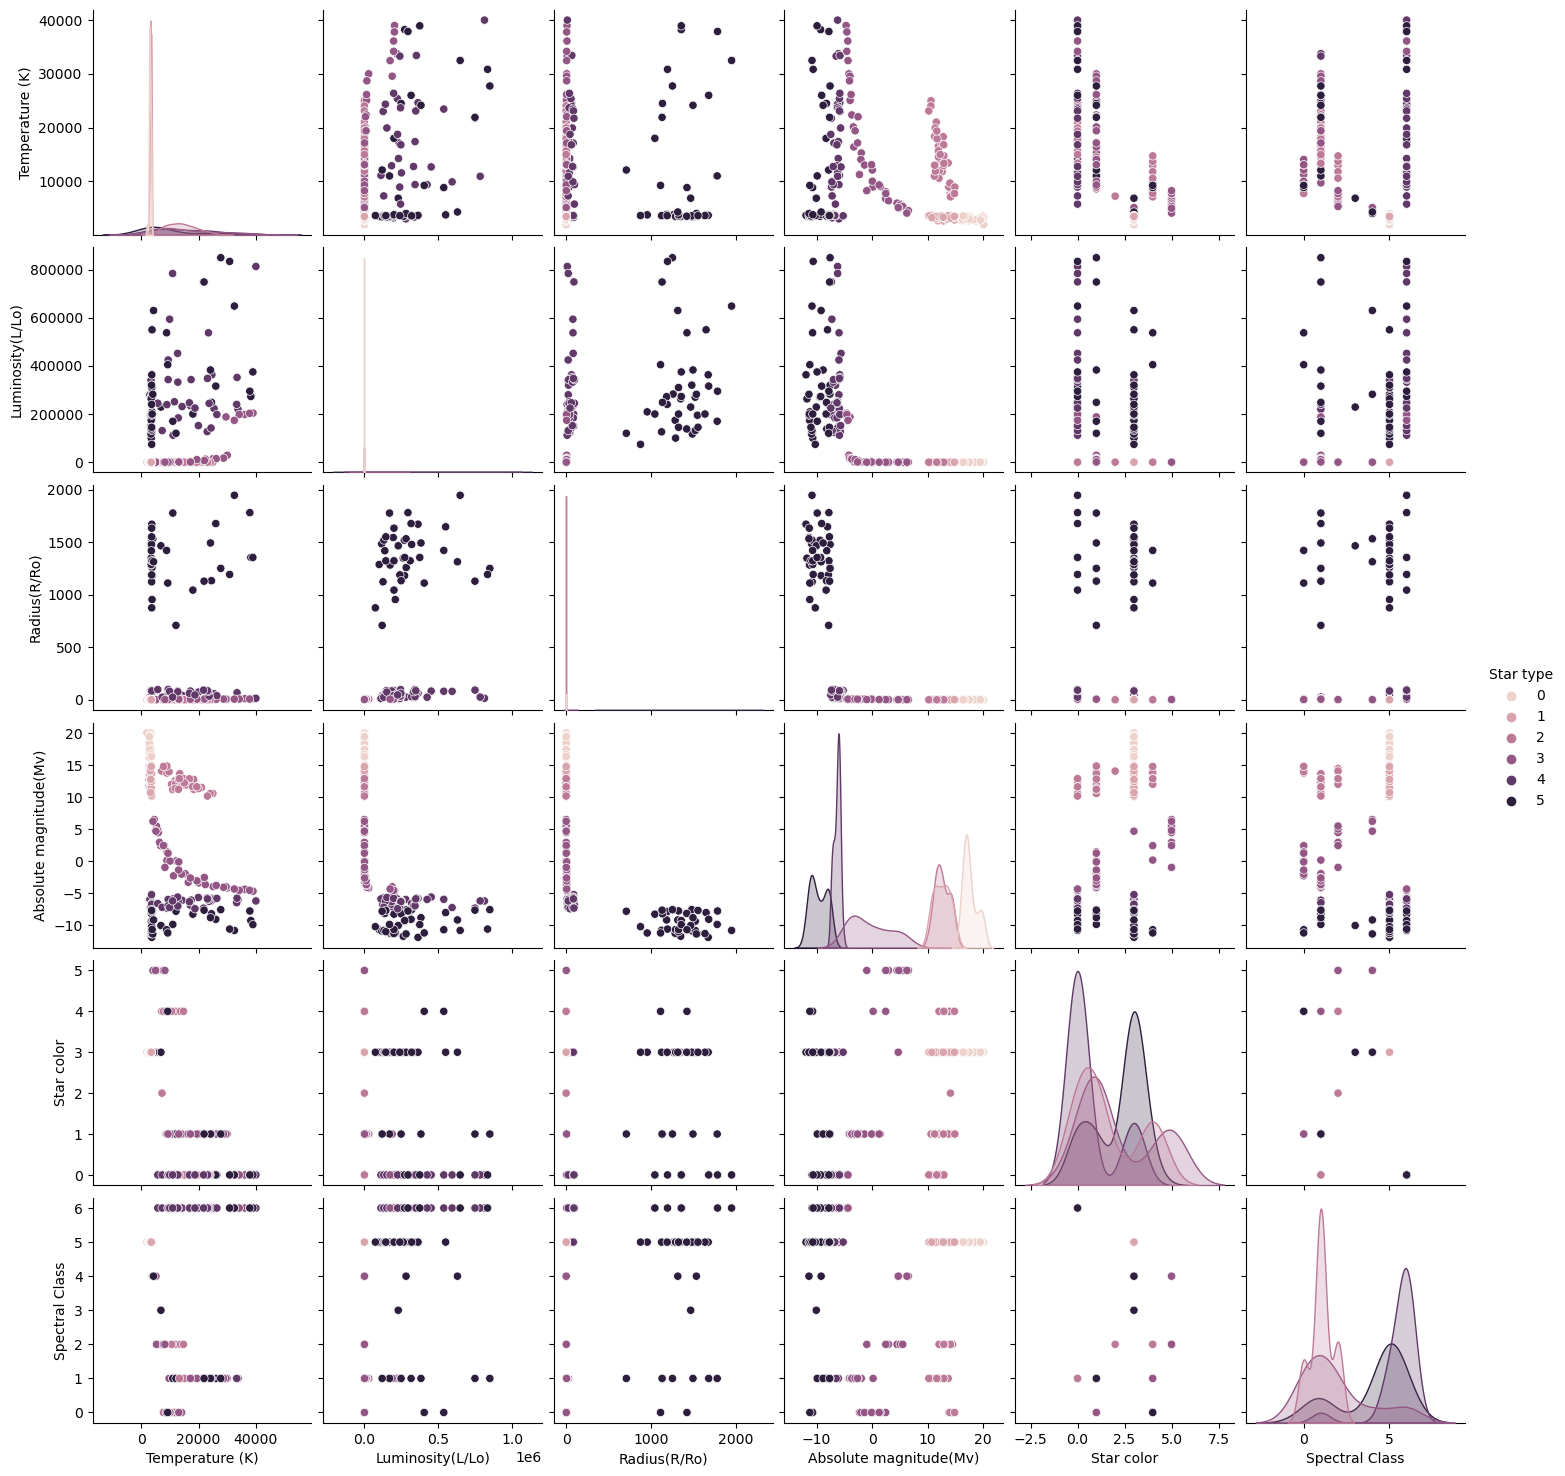

In [9]:
sns.pairplot(data, hue="Star type")

### 3.2 Feature Correlation Matrix

<Axes: >

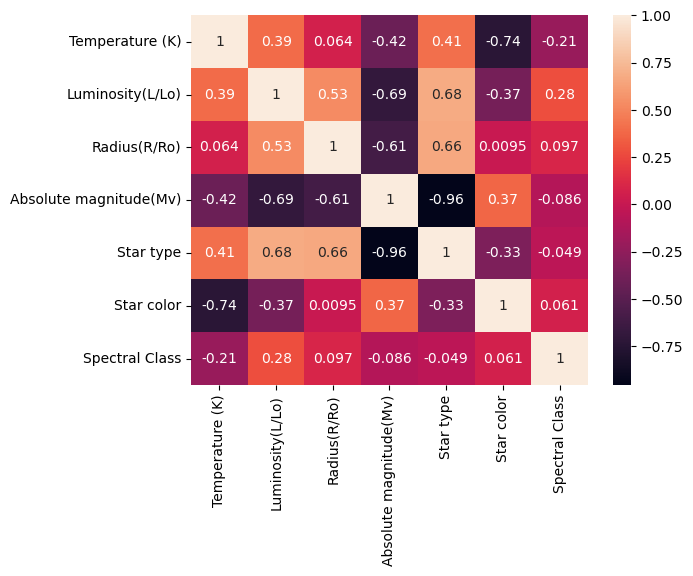

In [10]:
# Feature correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)

## 4. Data Splitting

In [11]:
# Define X and y
X = data.drop(['Spectral Class'], axis=1)
y = data.loc[:,'Spectral Class']

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## 5. Random Forest Classifier

### 5.1 Train and Evaluate Random Forest Classifier with Default Parameters

In [12]:
# Import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the classifier
rfc = RandomForestClassifier(random_state=0)

# Fit classifier to training set
rfc.fit(X_train, y_train)

# Make predictions on test set
y_pred = rfc.predict(X_test)

# Compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9375


### 5.2 Hyperparameter Tuning using Grid Search

In [13]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    # 'criterion': ['gini', 'entropy'],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['auto', 'sqrt', 'log2', None],
    # 'bootstrap': [True, False],
    # 'class_weight': ['balanced', None]
}

# Create the grid search object
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy',  # Use accuracy as the evaluation metric
                           n_jobs=-1)  # Use all available CPU cores

# Perform grid search on the training data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and the corresponding accuracy score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best parameters found by grid search:")
print(best_params_rf)
print("Best cross-validation accuracy score:", "{:.4f}".format(best_score_rf))

# Use the best model for prediction
best_model_rf = grid_search_rf.best_estimator_
y_pred_best = best_model_rf.predict(X_test)

# Compute accuracy score on the test set using the best model
test_acc_rf = accuracy_score(y_test, y_pred_best)
print('Accuracy score on the test set using the best model:', "{:.4f}".format(test_acc_rf))

c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found by grid search:
{'max_depth': None, 'n_estimators': 200}
Best cross-validation accuracy score: 0.9170
Accuracy score on the test set using the best model: 0.9167


### 5.3 Evaluation Metrics for Random Forest

In [14]:
# Compute evaluation metrics for Random Forest
y_pred_rf = rfc.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

## 6. KMeans Clustering

### 6.1 Hyperparameter Tuning for KMeans

In [15]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

# Define an extensive hyperparameter grid
param_grid_km = {
    'n_clusters': range(2, 11),
    'init': ['k-means++', 'random'],
    # 'algorithm': ['lloyd', 'full', 'elkan'],
    # 'max_iter': [300, 500],
    # 'tol': [1e-4, 1e-3],
    # 'n_init': [10, 20],
}

# Create KMeans model
kmeans = KMeans()

# Grid search with cross-validation
grid_search_km = GridSearchCV(kmeans, param_grid_km, cv=5)
grid_search_km.fit(data)

# Best model
best_model_km = grid_search_km.best_estimator_

# Best hyperparameters from grid search
best_params_km = grid_search_km.best_params_
print("Best parameters:", best_params_km)

c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment varia

Best parameters: {'init': 'k-means++', 'n_clusters': 10}


### 6.2 Plot Silhouette Scores for Different Values of K

c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment varia

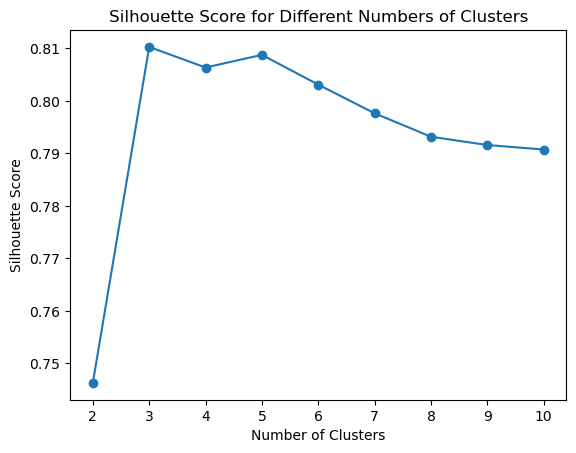

In [16]:
from sklearn.metrics import silhouette_score

# Define a range of cluster numbers to try
cluster_range = range(2, 11)

# Initialise an empty list to store silhouette scores
silhouette_scores = []

# Iterate over the cluster range
for k in cluster_range:
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Find the index of the maximum silhouette score
max_index = silhouette_scores.index(max(silhouette_scores))

# Plot silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

### 6.3 Train KMeans with Optimal Number of Clusters

In [17]:
# Print the highest silhouette score and the corresponding number of clusters
optimal_k = cluster_range[max_index]
print("Optimal number of clusters (K):", optimal_k)
print("Highest silhouette score:", "{:.4f}".format(max(silhouette_scores)))

Optimal number of clusters (K): 3
Highest silhouette score: 0.8103


In [18]:
from sklearn.cluster import KMeans

# Create KMeans model with optimised parameters for comparison
kmeans_tuned = KMeans(**best_params_km)

# Create KMeans model without optimised parameters for comparison
kmeans_untuned = KMeans(n_clusters=optimal_k, random_state=42)

# Fit the models to data
kmeans_tuned.fit(data)
kmeans_untuned.fit(data)

# Get and print silhouette scores of the two versions
kmeans_tuned_silhouette = silhouette_score(data, kmeans_tuned.labels_)
kmeans_untuned_silhouette = silhouette_score(data, kmeans_untuned.labels_)

print("Silhouette score of kmeans model with hyperparameter tuning:", "{:.4f}".format(kmeans_tuned_silhouette))
print("Silhouette score of kmeans model without hyperparameter tuning (but with optimal no. of clusters):", "{:.4f}".format(kmeans_untuned_silhouette))

c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment varia

Silhouette score of kmeans model with hyperparameter tuning: 0.7892
Silhouette score of kmeans model without hyperparameter tuning (but with optimal no. of clusters): 0.8103


### 6.4 Visualise the clusters using PCA

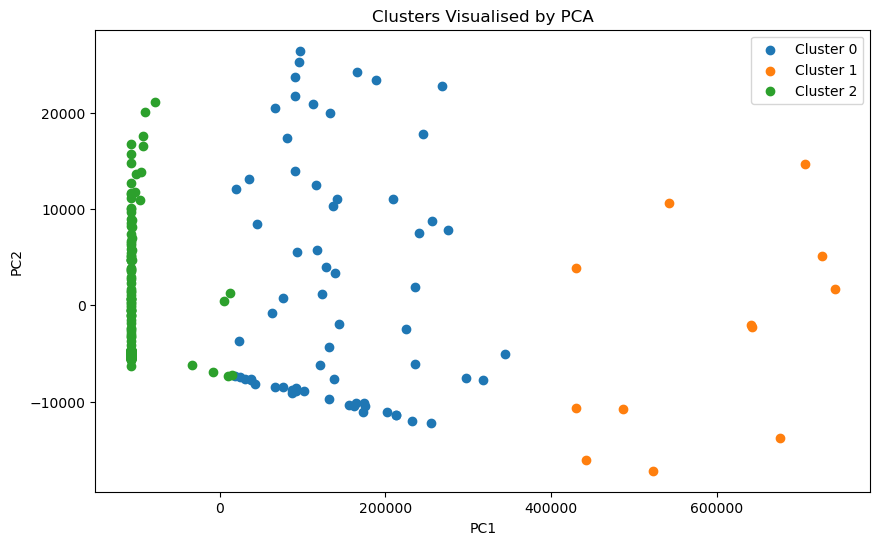

In [19]:
from sklearn.decomposition import PCA

# Proceed with the untuned version because of higher silhouette score
# Get cluster labels for data
labels = kmeans_untuned.labels_

# Add labels to DataFrame
data['Cluster'] = labels

# Visualise the clusters using PCA (Principal Component Analysis)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
cluster_df = pd.concat([principal_df, data['Cluster']], axis=1)

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    plt.scatter(cluster_df.loc[cluster_df['Cluster'] == cluster, 'PC1'],
                cluster_df.loc[cluster_df['Cluster'] == cluster, 'PC2'],
                label=f'Cluster {cluster}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters Visualised by PCA')
plt.legend()
plt.show()

## 7. Multi-Layer Perceptron (MLP)

### 7.1 Standardise Features

In [20]:
# Standardise features
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)
X_val_scaled = preprocessing.scale(X_val)

### 7.2 Hyperparameter Tuning for MLP using Keras Tuner

In [39]:
# Define the model-building function
def build_model_mlp(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the tuner
with tempfile.TemporaryDirectory() as tmp_dir:
    tuner = RandomSearch(
        build_model_mlp,
        objective='val_accuracy',
        max_trials=5,  # Number of hyperparameter combinations to try
        directory=tmp_dir, # Use the temporary directory
        project_name='mlp_tuning'
    )

# Start the search
tuner.search(X_train_scaled, y_train, epochs=1000, validation_data=(X_val_scaled, y_val))

# Get the best model
best_model_mlp = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 00m 43s]
val_accuracy: 0.9166666865348816

Best val_accuracy So Far: 0.9375
Total elapsed time: 00h 03m 24s


C:\Users\sgnyavar\AppData\Roaming\Python\Python310\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### 7.3 Evaluate the Best MLP Model

In [40]:
# Evaluate the best model on the test set
best_model_mlp = tuner.get_best_models(num_models=1)[0]
test_loss_mlp, test_acc_mlp = best_model_mlp.evaluate(X_test_scaled, y_test)
print('Test accuracy:', test_acc_mlp)

best_params_mlp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_params_mlp.values}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8542 - loss: 0.7699  
Test accuracy: 0.875
Best hyperparameters: {'units_1': 160, 'dropout_1': 0.30000000000000004, 'units_2': 448, 'dropout_2': 0.2, 'learning_rate': 0.01}


### 7.4 Compute Evaluation Metrics for MLP

In [41]:
# Predict probabilities for each class
y_pred_probs_mlp = best_model_mlp.predict(X_test_scaled)

# Get the predicted class labels by selecting the class with the highest probability
y_pred_mlp = y_pred_probs_mlp.argmax(axis=-1)

# Compute evaluation metrics
accuracy_mlp = test_acc_mlp
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 8. Convolutional Neural Network (CNN)

### 8.1 Reshape Data for CNN

In [42]:
# Reshape data for CNN
input_shape = (6, 1, 1)  # Each sample has 6 features and 1 channel

X_train_reshaped = X_train.values.reshape(-1, *input_shape)
X_test_reshaped = X_test.values.reshape(-1, *input_shape)

### 8.2 Hyperparameter Tuning for CNN using Keras Tuner

In [48]:
# Define the model-building function
def build_model_cnn(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32), (3, 1), activation='relu'))
    model.add(MaxPooling2D((2, 1)))
    model.add(Flatten())
    model.add(Dense(hp.Int('units_1', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the tuner
with tempfile.TemporaryDirectory() as tmp_dir:
    tuner = RandomSearch(
        build_model_cnn,
        objective='val_accuracy',
        max_trials=5, # Number of hyperparameter combinations to try
        directory=tmp_dir,  # Use the temporary directory
        project_name='cnn_tuning'
    )

# Start the search
tuner.search(X_train_reshaped, y_train, epochs=1000, validation_split=0.1)

# Get the best model
best_model_cnn = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 00m 40s]
val_accuracy: 0.9333333373069763

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 03m 23s


C:\Users\sgnyavar\AppData\Roaming\Python\Python310\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### 8.3 Evaluate the Best CNN Model

In [49]:
# Evaluate the best model on the test set
best_model_cnn = tuner.get_best_models(num_models=1)[0]
test_loss_cnn, test_acc_cnn = best_model_cnn.evaluate(X_test_reshaped, y_test)
print('Test accuracy:', test_acc_cnn)

# If you still need to access hyperparameters, use best_hps directly
best_params_cnn = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_params_cnn.values}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8021 - loss: 0.6882  
Test accuracy: 0.8125
Best hyperparameters: {'filters_1': 96, 'units_1': 256, 'learning_rate': 0.01}


### 8.4 Compute Evaluation Metrics for CNN

In [50]:
# Predict probabilities for each class
y_pred_probs_cnn = best_model_cnn.predict(X_test_reshaped)

# Get the predicted class labels by selecting the class with the highest probability
y_pred_cnn = y_pred_probs_cnn.argmax(axis=-1)

# Compute evaluation metrics
accuracy_cnn = test_acc_cnn
precision_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
recall_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Anaconda3\2023.03-1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 9. Model Comparison and Visualisation

### 9.1 Create a DataFrame to Store the Performance Metrics

In [51]:
# Define a dictionary to store the performance metrics for each model
models = ['Random Forest', 'MLP', 'CNN']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
solutions = {
    'Random Forest': {'Accuracy': accuracy_rf, 'Precision': precision_rf, 'Recall': recall_rf, 'F1 Score': f1_rf},
    'MLP': {'Accuracy': accuracy_mlp, 'Precision': precision_mlp, 'Recall': recall_mlp, 'F1 Score': f1_mlp},
    'CNN': {'Accuracy': accuracy_cnn, 'Precision': precision_cnn, 'Recall': recall_cnn, 'F1 Score': f1_cnn}
}

# A function to put the result of each performance metric for each model into a DataFrame
def plot_results(models, metrics):
    df = pd.DataFrame(index=models, columns=metrics)
    for model in models:
        for metric in metrics:
            df.loc[model, metric] = solutions[model][metric]
    return df

# Put the results into a DataFrame
result_df = plot_results(models, metrics)

# Printing the evaluation metrics as a DataFrame
print(result_df)

              Accuracy Precision  Recall  F1 Score
Random Forest   0.9375  0.960227  0.9375  0.931052
MLP              0.875  0.824541   0.875  0.846624
CNN             0.8125  0.753844  0.8125   0.77018


### 9.2 Plot the Evaluation Metrics

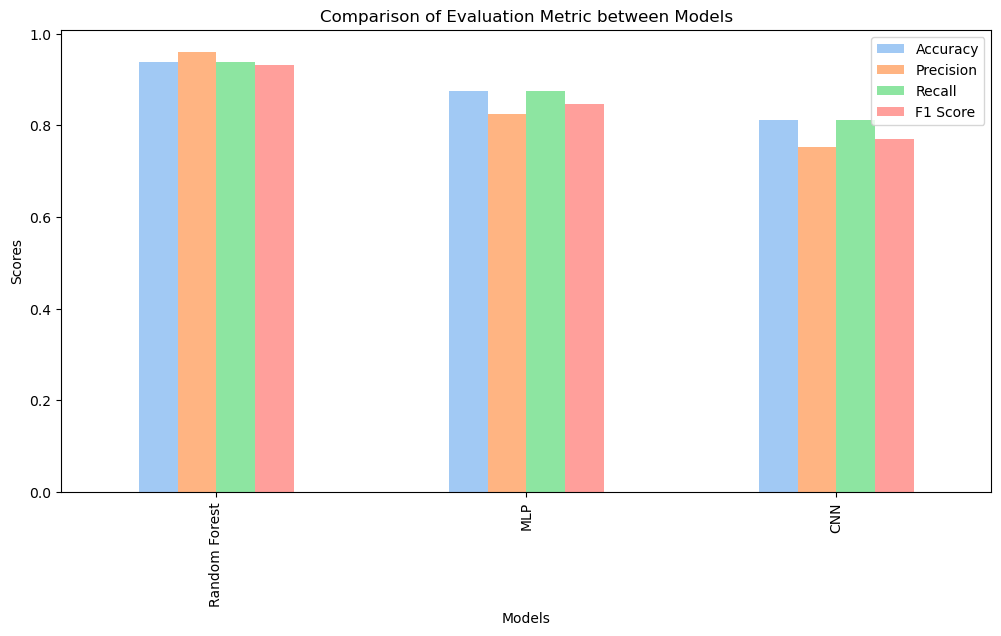

In [52]:
sns.set_palette("pastel")
ax = result_df.plot(kind='bar', figsize=(12, 6))
ax.set_ylabel('Scores')
ax.set_xlabel('Models')
ax.set_title('Comparison of Evaluation Metric between Models')

plt.show()